In [12]:
!pip install cohere

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Obtaining dependency information for cohere from https://files.pythonhosted.org/packages/19/20/8c2aba38eb739c25ca7f1e27dda8d3dacd970313680610f97234b8e7b10c/cohere-4.35-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.4/795.4 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 3.3 MB/s eta 0:00:00
  Created wheel for fastavro: filename=fastavro-1.8.2-cp310-cp310-macosx_11_0_arm64.whl size=440316 sha256=6dd123bcf86dd7664d12993847c0ba011f9f1204f0800084766ef8af80afe2d3
  Sto

# What's happening inside reranking ?

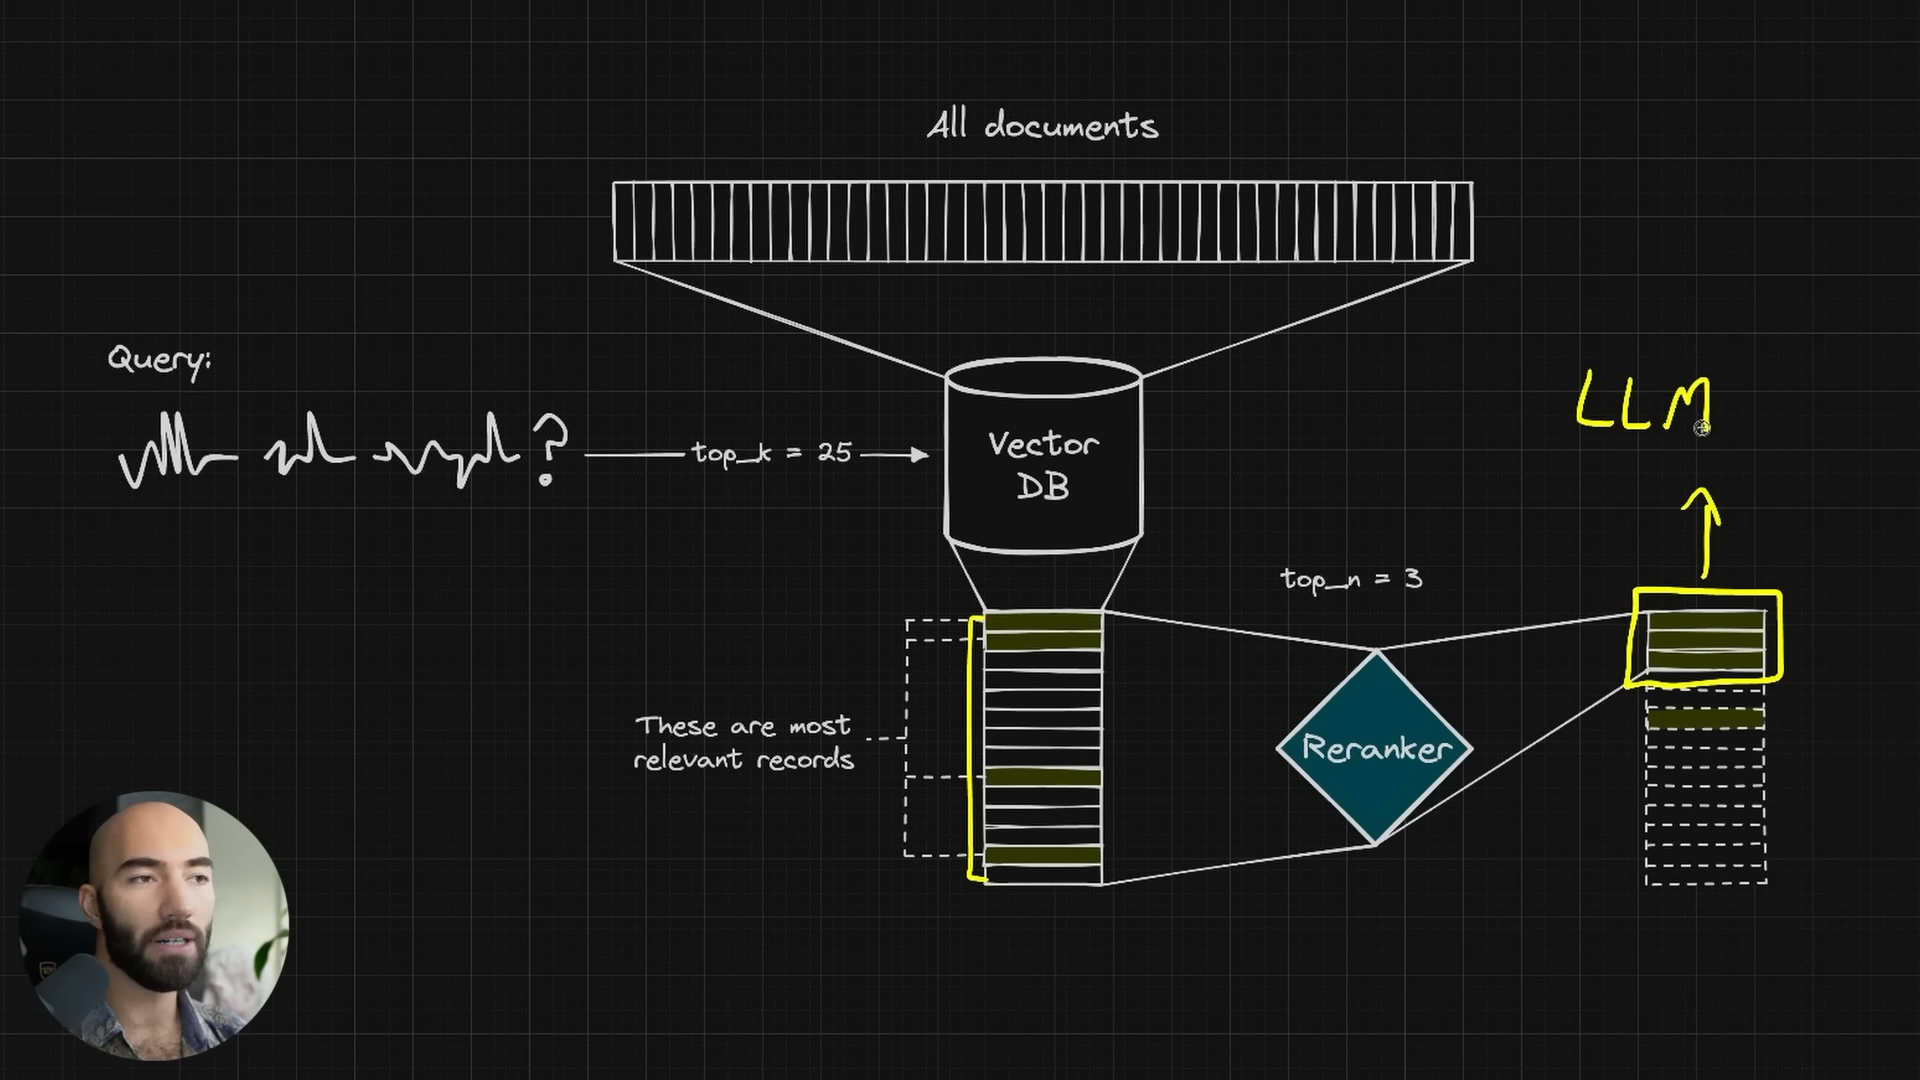

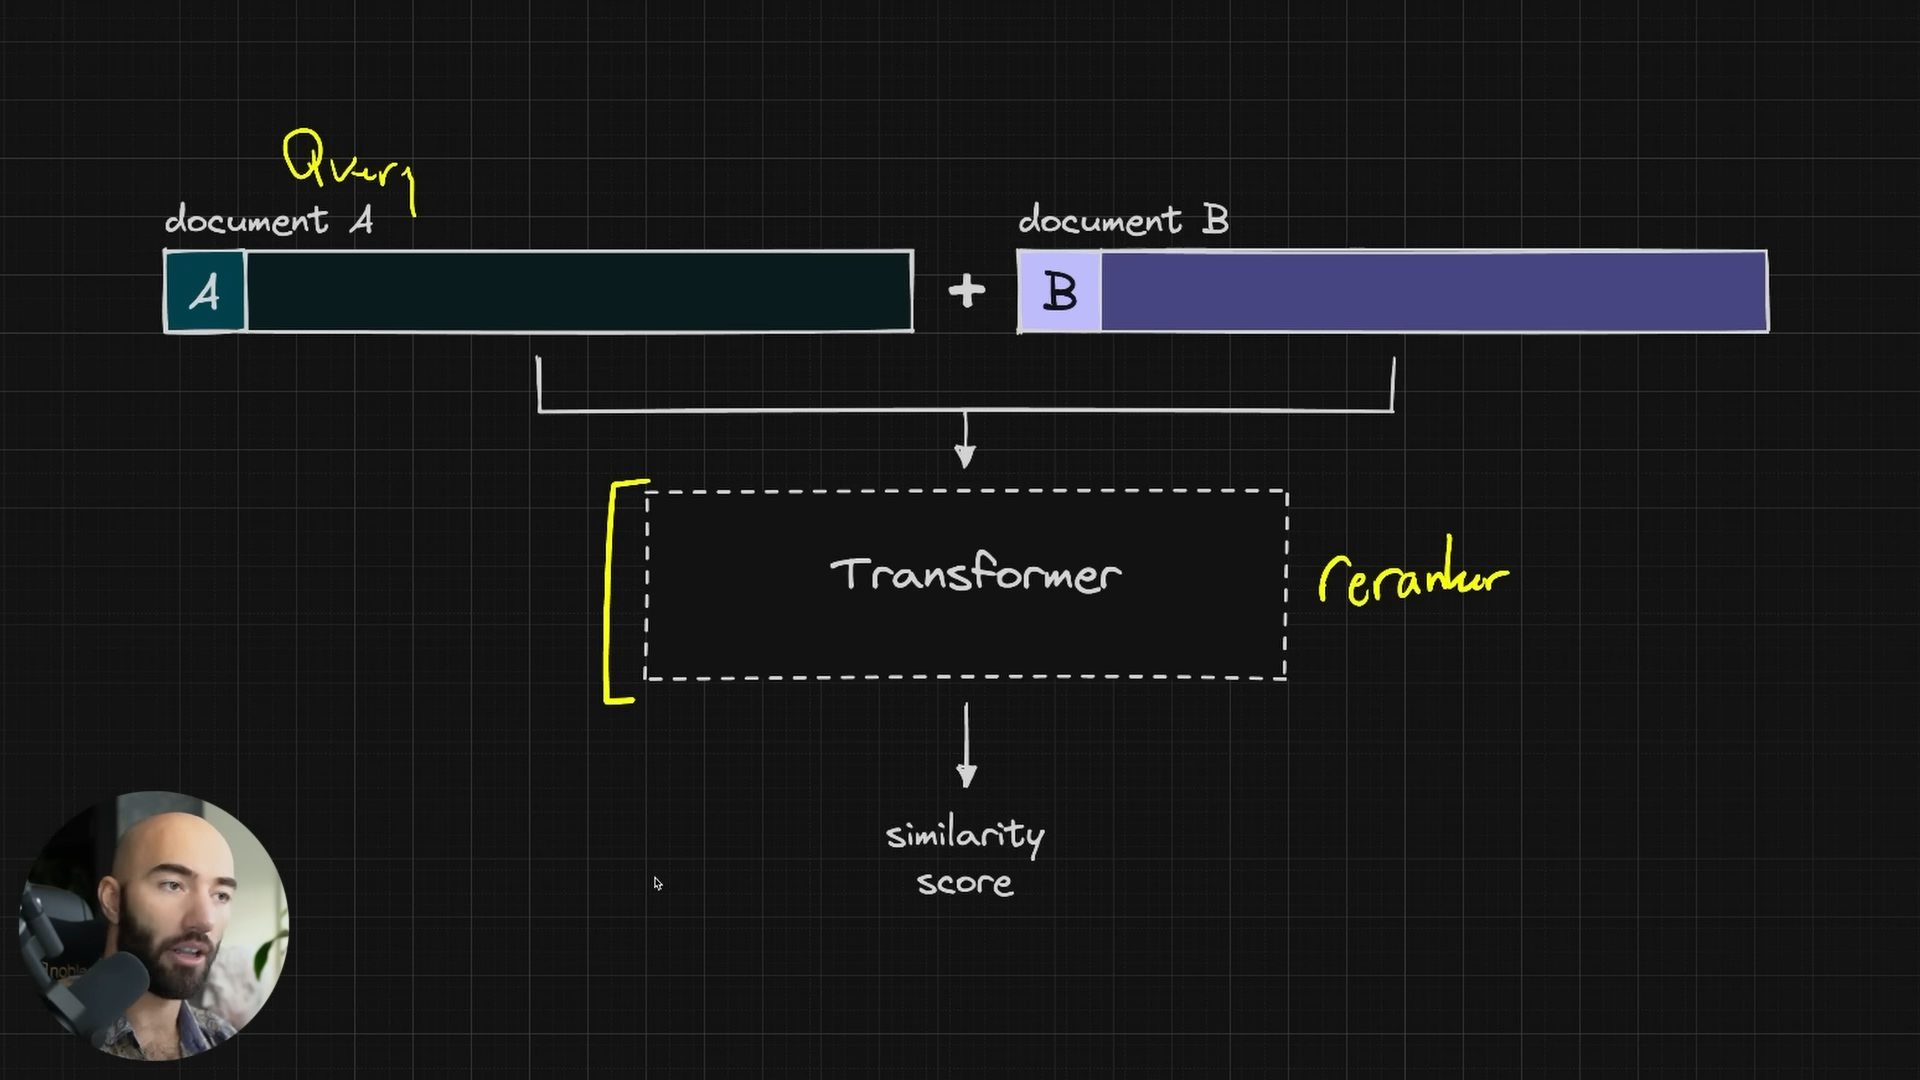

In [1]:
import yaml, os, openai, cohere
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['OPENAI_API_KEY'] = credentials['OPENAI_API_KEY']
os.environ['HUGGINGFACEHUB_API_TOKEN'] = credentials['HUGGINGFACEHUB_API_TOKEN']
os.environ["COHERE_API"] = credentials['COHERE_API']
os.environ['ENGINE'] = credentials['ENGINE']

openai.api_key = credentials['OPENAI_API_KEY']
openai.api_base = credentials['OPENAI_API_BASE']
openai.api_type = credentials['OPENAI_API_TYPE']
openai.api_version = credentials['OPENAI_API_VERSION']
openai.engine = credentials['ENGINE']

In [12]:
loader = DirectoryLoader(
                        'data/langchain_blog_posts/', 
                        loader_cls=TextLoader,
                        glob="./*.txt"
                        )

documents = loader.load()

#splitting the text into
text_splitter = RecursiveCharacterTextSplitter(
                                                chunk_size=1000, 
                                                chunk_overlap=200
                                                )
texts = text_splitter.split_documents(documents)

len(texts)

556

In [13]:
persist_directory = 'db/13'

embedding = HuggingFaceBgeEmbeddings(
                                    model_name="BAAI/bge-small-en-v1.5",
                                    model_kwargs={'device': 'mps'},
                                    encode_kwargs={'normalize_embeddings': True}
                                    )

llm = AzureChatOpenAI(
                    deployment_name=credentials['AD_DEPLOYMENT_ID'],
                    model_name=credentials['AD_ENGINE'],
                    temperature=0.9, 
                    max_tokens=256
                    )

co = cohere.Client(os.environ["COHERE_API"])

vectordb = Chroma.from_documents(
                                documents=texts, 
                                embedding=embedding,
                                persist_directory=persist_directory
                                )

In [14]:
# persiste the db to disk
vectordb.persist()
vectordb = None

In [15]:
vectordb = Chroma(
                persist_directory=persist_directory, 
                embedding_function=embedding
                )

In [37]:
query = "What is Langsmith?"

### Basic Retriever

In [38]:
vectordb = Chroma(
                persist_directory=persist_directory, 
                embedding_function=embedding
                )
retriever = vectordb.as_retriever(search_kwargs={"k": 25})

In [39]:
docs = retriever.get_relevant_documents(query)
docs

[Document(page_content='Since the launch of HelpHub, we were trying to do things on hard mode when it came to iterating and improving functionality. That is, of course, until the LangChain team tantalized us onto their LangSmith beta. What we didn’t expect was how immediate the downstream improvements were to our flagship AI-powered product.\n\nBut is LangSmith robust enough for us to rely on entirely for our LLM-powered QA? Or is it just another nice-to-have feature for our ENG team?\n\nIf you’re at the intersection of product, LLMs, and user experience, we’ve just walked so you can run. Time to read on.\n\nWhat Is LangSmith?\n\nLangSmith is a framework built on the shoulders of LangChain. It’s designed to track the inner workings of LLMs and AI agents within your product.\n\nThose LLM inner-workings can be categorized into 4 main buckets - each with its own flair of usefulness. Here’s a breakdown of how they all work in unison and what you can expect.\n\n\n\nDebugging:', metadata={'s

### With Reranker

In [40]:
rerank_docs = co.rerank(
                        query=query, 
                        documents=[doc_.page_content for doc_ in docs], 
                        top_n=25, 
                        model="rerank-english-v2.0"
                        )

In [41]:
print(rerank_docs[0].document["text"])

Since the launch of HelpHub, we were trying to do things on hard mode when it came to iterating and improving functionality. That is, of course, until the LangChain team tantalized us onto their LangSmith beta. What we didn’t expect was how immediate the downstream improvements were to our flagship AI-powered product.

But is LangSmith robust enough for us to rely on entirely for our LLM-powered QA? Or is it just another nice-to-have feature for our ENG team?

If you’re at the intersection of product, LLMs, and user experience, we’ve just walked so you can run. Time to read on.

What Is LangSmith?

LangSmith is a framework built on the shoulders of LangChain. It’s designed to track the inner workings of LLMs and AI agents within your product.

Those LLM inner-workings can be categorized into 4 main buckets - each with its own flair of usefulness. Here’s a breakdown of how they all work in unison and what you can expect.



Debugging:


In [48]:
[doc.document["text"] for doc in rerank_docs]

['Since the launch of HelpHub, we were trying to do things on hard mode when it came to iterating and improving functionality. That is, of course, until the LangChain team tantalized us onto their LangSmith beta. What we didn’t expect was how immediate the downstream improvements were to our flagship AI-powered product.\n\nBut is LangSmith robust enough for us to rely on entirely for our LLM-powered QA? Or is it just another nice-to-have feature for our ENG team?\n\nIf you’re at the intersection of product, LLMs, and user experience, we’ve just walked so you can run. Time to read on.\n\nWhat Is LangSmith?\n\nLangSmith is a framework built on the shoulders of LangChain. It’s designed to track the inner workings of LLMs and AI agents within your product.\n\nThose LLM inner-workings can be categorized into 4 main buckets - each with its own flair of usefulness. Here’s a breakdown of how they all work in unison and what you can expect.\n\n\n\nDebugging:',
 'URL: https://blog.langchain.dev/

In [51]:
def compare(
            query: str, 
            top_k: int, 
            top_n: int
            ):

    docs = retriever.get_relevant_documents(query)
    docs = [doc_.page_content for doc_ in docs]
    i2doc = {idx : doc for idx, doc in enumerate(docs)}
    docid = {doc : idx for idx, doc in enumerate(docs)}

    rerank_docs = co.rerank(
                            query=query, 
                            documents=docs, 
                            top_n=top_n, 
                            model="rerank-english-v2.0"
                            )
    original_docs = []
    reranked_docs = []
    # compare order change
    for i, doc in enumerate(rerank_docs):
        rerank_i = docid[doc.document["text"]]
        print(str(i)+"\t->\t"+str(rerank_i))
        if i != rerank_i:
            reranked_docs.append(f"[{rerank_i}]\n"+doc.document["text"])
            original_docs.append(f"[{i}]\n"+i2doc[i])
    for orig, rerank in zip(original_docs, reranked_docs):
        print("ORIGINAL:\n"+orig+"\n\nRERANKED:\n"+rerank+"\n\n---\n")

In [52]:
compare(query, 25, 3)

0	->	0
1	->	9
2	->	15
ORIGINAL:
[1]
Conclusion

Ragas enhances QA system evaluation by addressing limitations in traditional metrics and leveraging Large Language Models. LangSmith provides a platform for running evaluations and visualizing results.

By using Ragas and LangSmith, you can ensure your QA systems are robust and ready for real-world applications, making the development process more efficient and reliable.

RERANKED:
[9]
URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at address

In [53]:
compare("what is langchain", 25, 3)

0	->	2
1	->	5
2	->	15
ORIGINAL:
[0]
https://twitter.com/zhanghaili0610

LangChain vs LangSmith: What’s the difference?

While LangChain is the muscle doing the heavy lifting with Chains, Prompts, and Agents, understanding the 'why' behind the decisions LLMs make is a maze we often found ourselves lost in. That's where LangSmith shines, acting as an AI compass built into LangChain, guiding us through the intricate decision pathways and results that our chatbot generates.

"LangChain's (the company's) goal is to make it as easy as possible to develop LLM applications"

said Harrison Chase, co-founder and CEO of LangChain.

RERANKED:
[2]
LangChain is an open-source library that provides multiple tools to build applications powered by Large Language Models (LLMs), making it a perfect combination with Eden AI.

Within the LangChain ecosystem, Eden AI empowers users to fully leverage LLM providers without encountering any limitations. Here is how:



1. A unified platform to access multiple 